In [1]:
import typing as tp
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
outputs_dir = Path('.').resolve().parent.parent.parent / "outputs"
log_file_path = outputs_dir / "2022-10-03/17-14-25/image_attention.log"

In [2]:
def load_records(log_path: Path) -> tp.List[tp.Dict[str, tp.Any]]:
    with open(log_path) as f:
        return [json.loads(line.rstrip()) for line in f]

In [3]:
def load_log_records(*log_files_paths: Path) -> pd.DataFrame:
    files_records = []
    for log_file_path in log_files_paths:
        log_records = load_records(log_file_path)
        log_records = [record for record in log_records if record['message'] is None]
        files_records.extend(log_records)

    log_records_df = pd.json_normalize(files_records).drop(columns=['message', 'asctime'])
    return log_records_df

In [15]:
log_records_df = load_log_records(log_file_path)
log_records_df.head()

,name,levelname,alpha,acc1,acc5,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_value_strategy.scale,cache_weights_strategy._target_,cache_weights_strategy.beta
0,image_attention,INFO,0.0,55.627410,89.764955,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
1,image_attention,INFO,0.1,55.366248,89.665464,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
2,image_attention,INFO,0.5,54.756871,89.105833,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
3,image_attention,INFO,1.0,53.861460,88.521328,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
4,image_attention,INFO,2.0,51.187663,86.854869,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1


In [16]:
# adding hard_cache strategy
hard_cache_log_file_path = outputs_dir / "2022-09-20/15-41-49/image_attention.log"
hard_log_records_df = load_log_records(hard_cache_log_file_path)

hard_log_records_df['cache_value_strategy._target_'] = 'summer_clip.clip_searcher.cache_value_strategy.SoftmaxCacheStrategy'
hard_log_records_df['cache_value_strategy.scale'] = 'hard_cache'

log_records_df = pd.concat([log_records_df, hard_log_records_df], ignore_index=True)
log_records_df.head()

,name,levelname,alpha,acc1,acc5,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_value_strategy.scale,cache_weights_strategy._target_,cache_weights_strategy.beta
0,image_attention,INFO,0.0,55.627410,89.764955,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
1,image_attention,INFO,0.1,55.366248,89.665464,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
2,image_attention,INFO,0.5,54.756871,89.105833,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
3,image_attention,INFO,1.0,53.861460,88.521328,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
4,image_attention,INFO,2.0,51.187663,86.854869,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1


In [4]:
def add_zero_shots(log_records_df: pd.DataFrame, column_to_value: tp.Dict[str, tp.Any]) -> pd.DataFrame:
    zero_shot_df = log_records_df[log_records_df['alpha'] == 0].copy()
    for col_name, col_value in column_to_value.items():
        zero_shot_df[col_name] = col_value
    zero_shot_dfs = []

    for alpha in log_records_df['alpha'].unique():
        alpha_df = zero_shot_df.copy()
        alpha_df['alpha'] = alpha
        zero_shot_dfs.append(alpha_df)

    return pd.concat([log_records_df] + zero_shot_dfs, ignore_index=True)

In [18]:
log_records_df = add_zero_shots(log_records_df, {'cache_value_strategy.scale': 'zero_shot'})

log_records_df.head()

,name,levelname,alpha,acc1,acc5,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_value_strategy.scale,cache_weights_strategy._target_,cache_weights_strategy.beta
0,image_attention,INFO,0.0,55.627410,89.764955,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
1,image_attention,INFO,0.1,55.366248,89.665464,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
2,image_attention,INFO,0.5,54.756871,89.105833,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
3,image_attention,INFO,1.0,53.861460,88.521328,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
4,image_attention,INFO,2.0,51.187663,86.854869,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1


In [19]:
visible_params = {
    'alpha', 'acc1', 'acc5', 'cache_strategy.topk',
    'cache_weights_strategy.beta', 'cache_value_strategy.scale'
}
static_columns = list(set(log_records_df.columns) - visible_params)
groups = list(log_records_df.groupby(static_columns))
print('# unique groups:', len(groups))

# unique groups: 1


In [20]:
static_values, part_df = groups[0]
static_items = dict(zip(static_columns, static_values))
static_items  # type: ignore

{'cache_strategy._target_': 'summer_clip.clip_searcher.cache_strategy.TopKStrategy',
 'name': 'image_attention',
 'cache_value_strategy._target_': 'summer_clip.clip_searcher.cache_value_strategy.SoftmaxCacheStrategy',
 'levelname': 'INFO',
 'cache_weights_strategy._target_': 'summer_clip.clip_searcher.cache_weights_strategy.TipAdapterWeightsStrategy'}

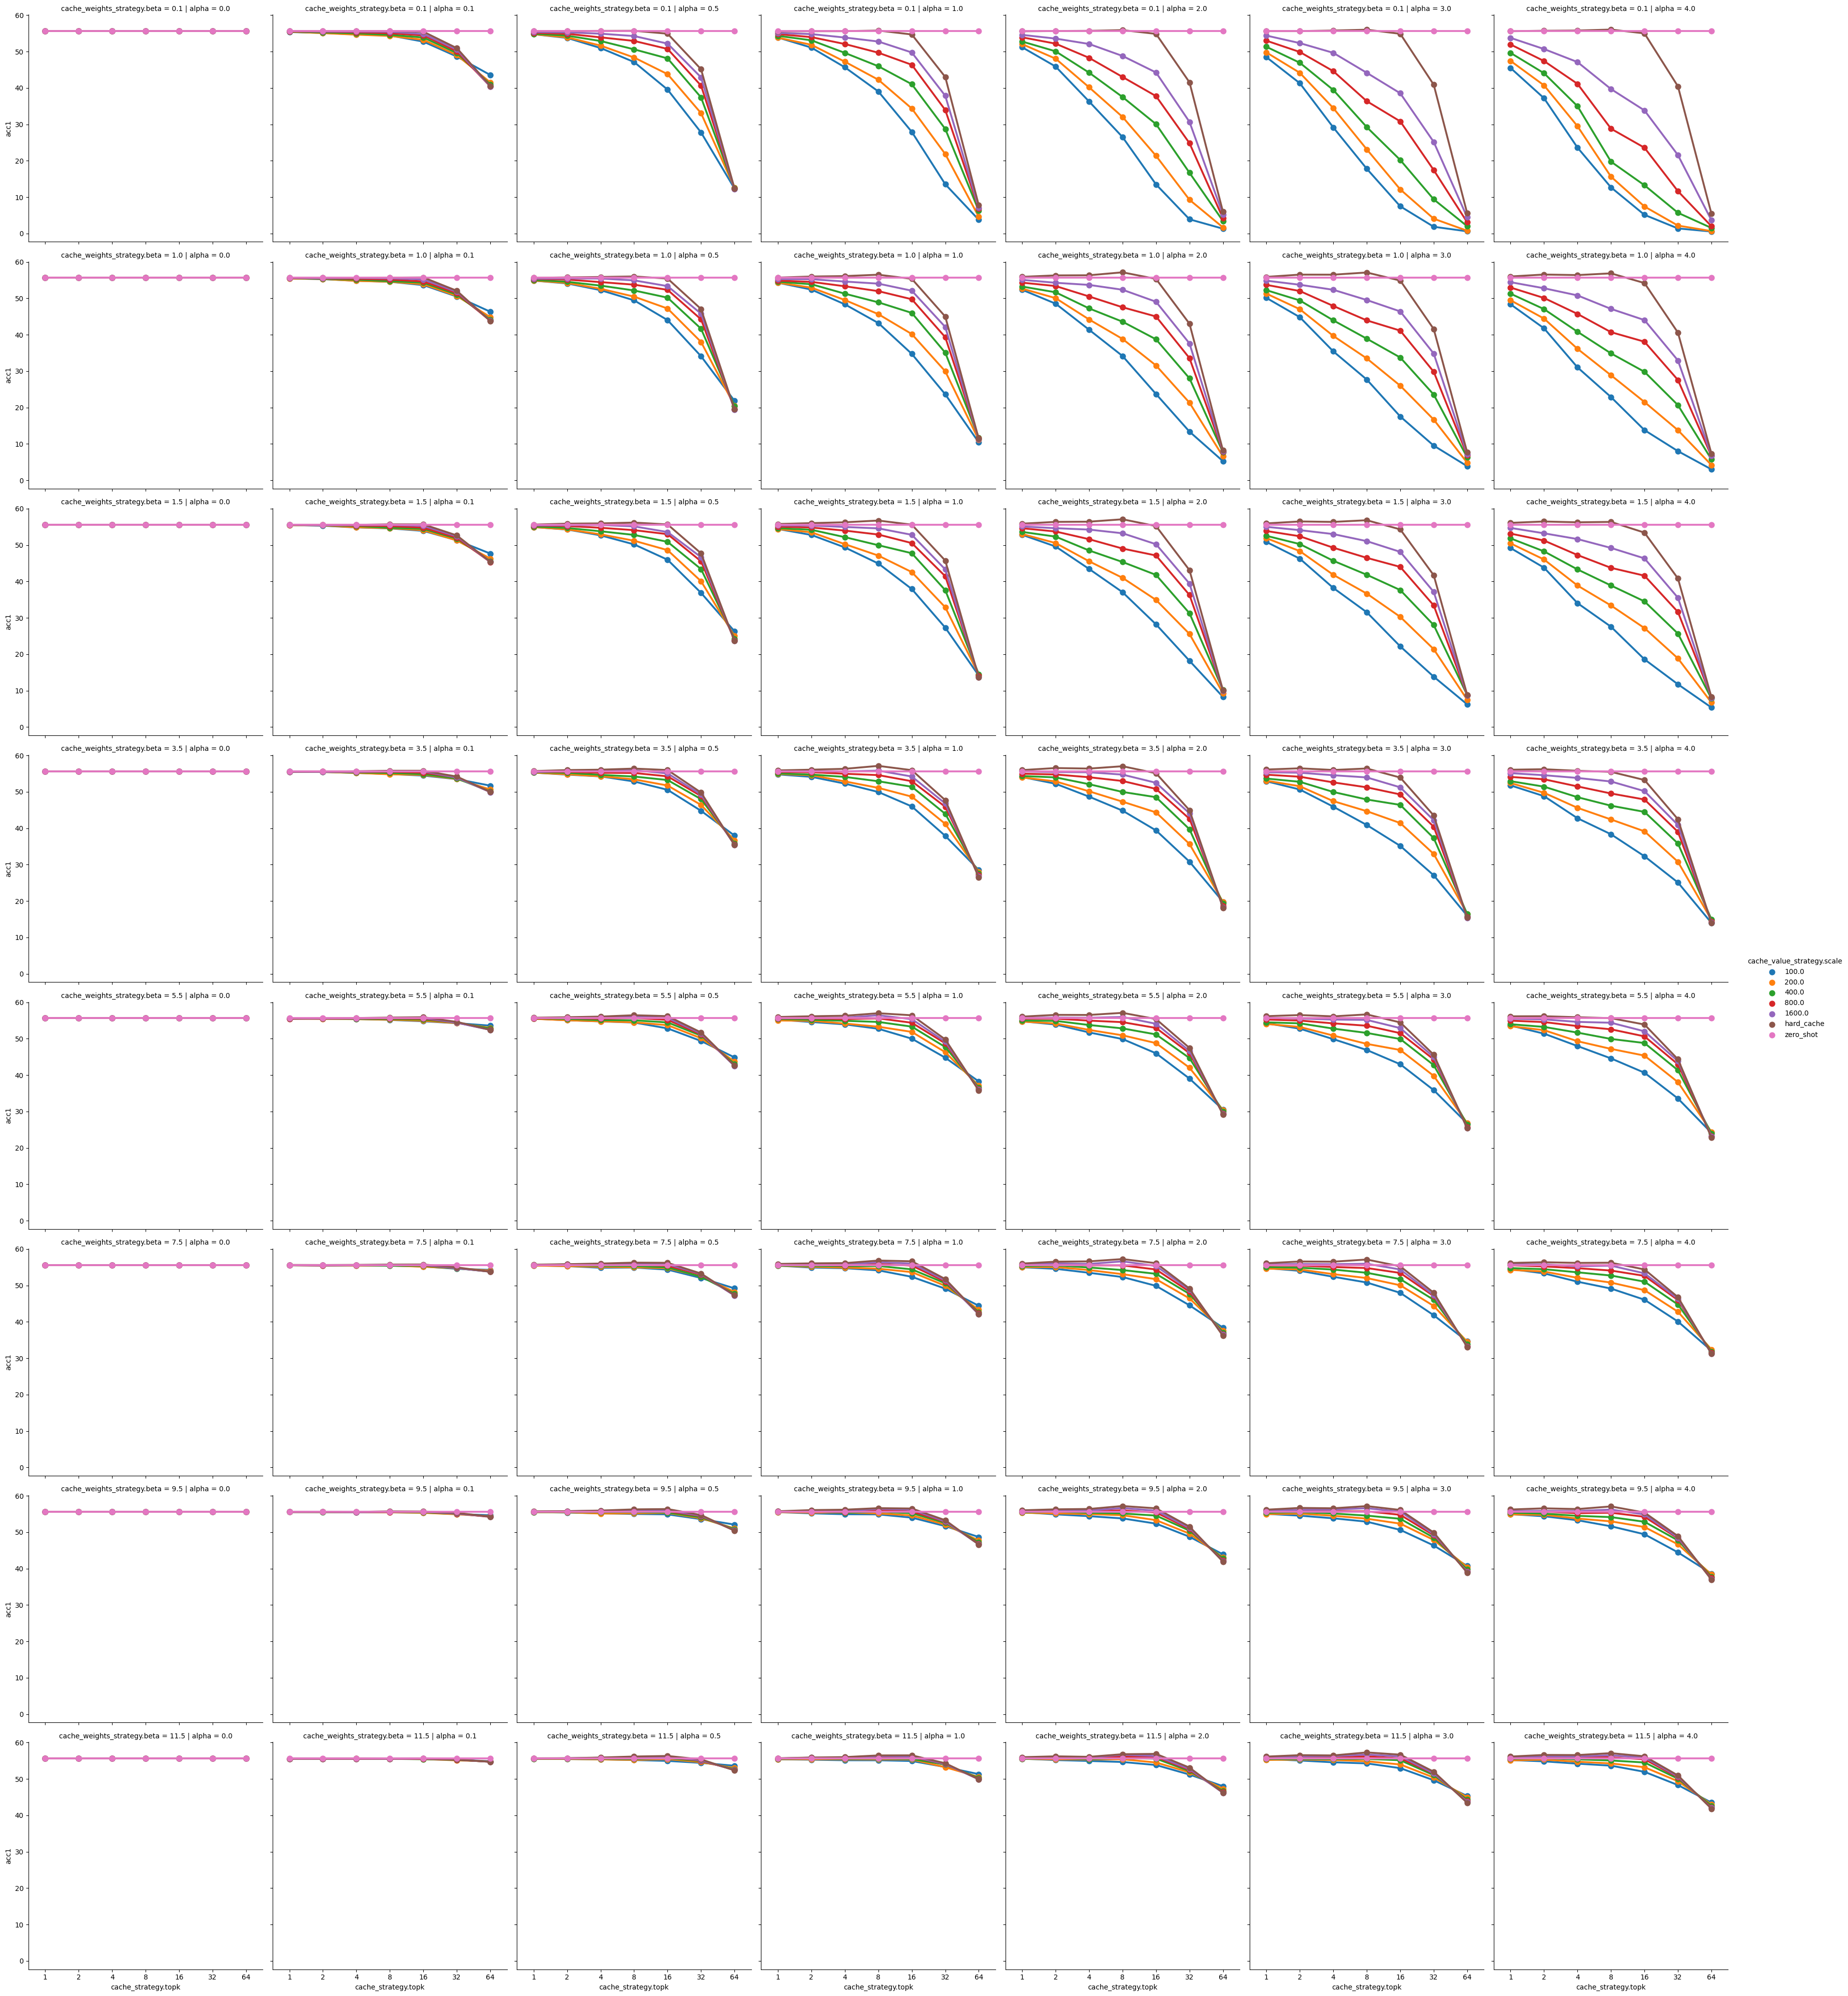

In [21]:
sns.catplot(
    data=part_df, x='cache_strategy.topk', y='acc1', col='alpha',
    row='cache_weights_strategy.beta', kind='point', hue='cache_value_strategy.scale'
)
plt.savefig('data/clip_search_6.pdf')

In [22]:
log_records_df.sort_values('acc1', ascending=False).head()

,name,levelname,alpha,acc1,acc5,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_value_strategy.scale,cache_weights_strategy._target_,cache_weights_strategy.beta
2182,image_attention,INFO,3.0,57.293869,89.752518,summer_clip.clip_searcher.cache_strategy.TopKS...,8,summer_clip.clip_searcher.cache_value_strategy...,hard_cache,summer_clip.clip_searcher.cache_weights_strate...,11.5
2167,image_attention,INFO,2.0,57.244124,89.541102,summer_clip.clip_searcher.cache_strategy.TopKS...,8,summer_clip.clip_searcher.cache_value_strategy...,hard_cache,summer_clip.clip_searcher.cache_weights_strate...,7.5
2174,image_attention,INFO,2.0,57.194379,89.740082,summer_clip.clip_searcher.cache_strategy.TopKS...,8,summer_clip.clip_searcher.cache_value_strategy...,hard_cache,summer_clip.clip_searcher.cache_weights_strate...,9.5
2175,image_attention,INFO,3.0,57.169506,89.454048,summer_clip.clip_searcher.cache_strategy.TopKS...,8,summer_clip.clip_searcher.cache_value_strategy...,hard_cache,summer_clip.clip_searcher.cache_weights_strate...,9.5
2139,image_attention,INFO,2.0,57.144634,88.297475,summer_clip.clip_searcher.cache_strategy.TopKS...,8,summer_clip.clip_searcher.cache_value_strategy...,hard_cache,summer_clip.clip_searcher.cache_weights_strate...,1.0


In [23]:
log_records_df[log_records_df['alpha'] == 0].head(1)

,name,levelname,alpha,acc1,acc5,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_value_strategy.scale,cache_weights_strategy._target_,cache_weights_strategy.beta
0,image_attention,INFO,0.0,55.62741,89.764955,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1


## Samples strategy comparison

In [10]:
# log_files_paths = [
#     outputs_dir / "2022-09-20/15-41-49/image_attention.log",
#     outputs_dir / "2022-10-03/18-48-02/image_attention.log",
#     outputs_dir / "2022-09-20/16-01-49/image_attention.log",
#     outputs_dir / "2022-09-20/16-02-53/image_attention.log",
#     outputs_dir / "2022-09-20/16-04-09/image_attention.log",
#     outputs_dir / "2022-09-21/11-24-36/image_attention.log",
# ]

In [20]:
log_files_paths = [
    outputs_dir / "2022-09-21/22-17-29/image_attention.log",
    outputs_dir / "2022-10-03/18-53-02/image_attention.log",
    outputs_dir / "2022-09-21/23-30-23/image_attention.log",
    outputs_dir / "2022-09-21/23-31-27/image_attention.log",
    outputs_dir / "2022-09-21/23-09-05/image_attention.log",
    outputs_dir / "2022-09-21/23-13-21/image_attention.log",
]

In [21]:
log_records_df = load_log_records(*log_files_paths)

log_records_df.head()

,name,levelname,alpha,acc1,acc5,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_weights_strategy._target_,cache_weights_strategy.beta,cache_strategy.cache_dataset._target_,cache_strategy.cache_dataset.dataset,cache_strategy.cache_dataset.split,cache_strategy.cache_dataset.root_path,cache_strategy.cache_dataset.shots,cache_strategy.cache_dataset.is_train,cache_strategy.cache_dataset.use_custom_preprocess,cache_strategy.cache_dataset.load_images
0,image_attention,INFO,0.0,55.627410,89.764955,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,image_attention,INFO,0.1,56.050243,89.491357,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,image_attention,INFO,0.5,55.540356,88.770053,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,image_attention,INFO,1.0,52.481035,87.290138,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,image_attention,INFO,2.0,45.106330,82.738465,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
def fill_topk(log_records_df: pd.DataFrame) -> pd.DataFrame:
    topk_mask = log_records_df['cache_strategy.topk'].isna()
    full_topk_df = log_records_df[~topk_mask]
    empty_topk_df = log_records_df[topk_mask]

    topk_dfs = []
    for topk in full_topk_df['cache_strategy.topk'].unique():
        topk_df = empty_topk_df.copy()
        topk_df['cache_strategy.topk'] = topk
        topk_dfs.append(topk_df)

    return pd.concat([full_topk_df] + topk_dfs, ignore_index=True)

In [23]:
log_records_df = fill_topk(log_records_df)

log_records_df.head()

,name,levelname,alpha,acc1,acc5,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_weights_strategy._target_,cache_weights_strategy.beta,cache_strategy.cache_dataset._target_,cache_strategy.cache_dataset.dataset,cache_strategy.cache_dataset.split,cache_strategy.cache_dataset.root_path,cache_strategy.cache_dataset.shots,cache_strategy.cache_dataset.is_train,cache_strategy.cache_dataset.use_custom_preprocess,cache_strategy.cache_dataset.load_images
0,image_attention,INFO,0.0,55.627410,89.764955,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,image_attention,INFO,0.1,56.050243,89.491357,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,image_attention,INFO,0.5,55.540356,88.770053,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,image_attention,INFO,1.0,52.481035,87.290138,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,image_attention,INFO,2.0,45.106330,82.738465,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
columns_to_drop = [
    column for column in log_records_df.columns
    if column.startswith('cache_strategy.cache_dataset')
]
log_records_df = log_records_df.drop(columns=columns_to_drop)
log_records_df.head()

,name,levelname,alpha,acc1,acc5,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_weights_strategy._target_,cache_weights_strategy.beta
0,image_attention,INFO,0.0,55.627410,89.764955,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
1,image_attention,INFO,0.1,56.050243,89.491357,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
2,image_attention,INFO,0.5,55.540356,88.770053,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
3,image_attention,INFO,1.0,52.481035,87.290138,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
4,image_attention,INFO,2.0,45.106330,82.738465,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1


In [25]:
log_records_df = add_zero_shots(log_records_df, {'cache_strategy._target_': 'summer_clip.clip_searcher.cache_strategy.ZeroShotStrategy'})

log_records_df.head()

,name,levelname,alpha,acc1,acc5,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_weights_strategy._target_,cache_weights_strategy.beta
0,image_attention,INFO,0.0,55.627410,89.764955,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
1,image_attention,INFO,0.1,56.050243,89.491357,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
2,image_attention,INFO,0.5,55.540356,88.770053,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
3,image_attention,INFO,1.0,52.481035,87.290138,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
4,image_attention,INFO,2.0,45.106330,82.738465,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1


In [26]:
visible_params = {
    'alpha', 'acc1', 'acc5', 'cache_strategy.topk',
    'cache_weights_strategy.beta', 'cache_value_strategy.scale',
    'cache_strategy._target_',
}
static_columns = list(set(log_records_df.columns) - visible_params)
groups = list(log_records_df.groupby(static_columns, dropna=False))
print('# unique groups:', len(groups))

# unique groups: 1


In [27]:
static_values, part_df = groups[0]
static_items = dict(zip(static_columns, static_values))
static_items  # type: ignore

{'levelname': 'INFO',
 'name': 'image_attention',
 'cache_weights_strategy._target_': 'summer_clip.clip_searcher.cache_weights_strategy.TipAdapterWeightsStrategy',
 'cache_value_strategy._target_': 'summer_clip.clip_searcher.cache_value_strategy.HardCacheStrategy'}

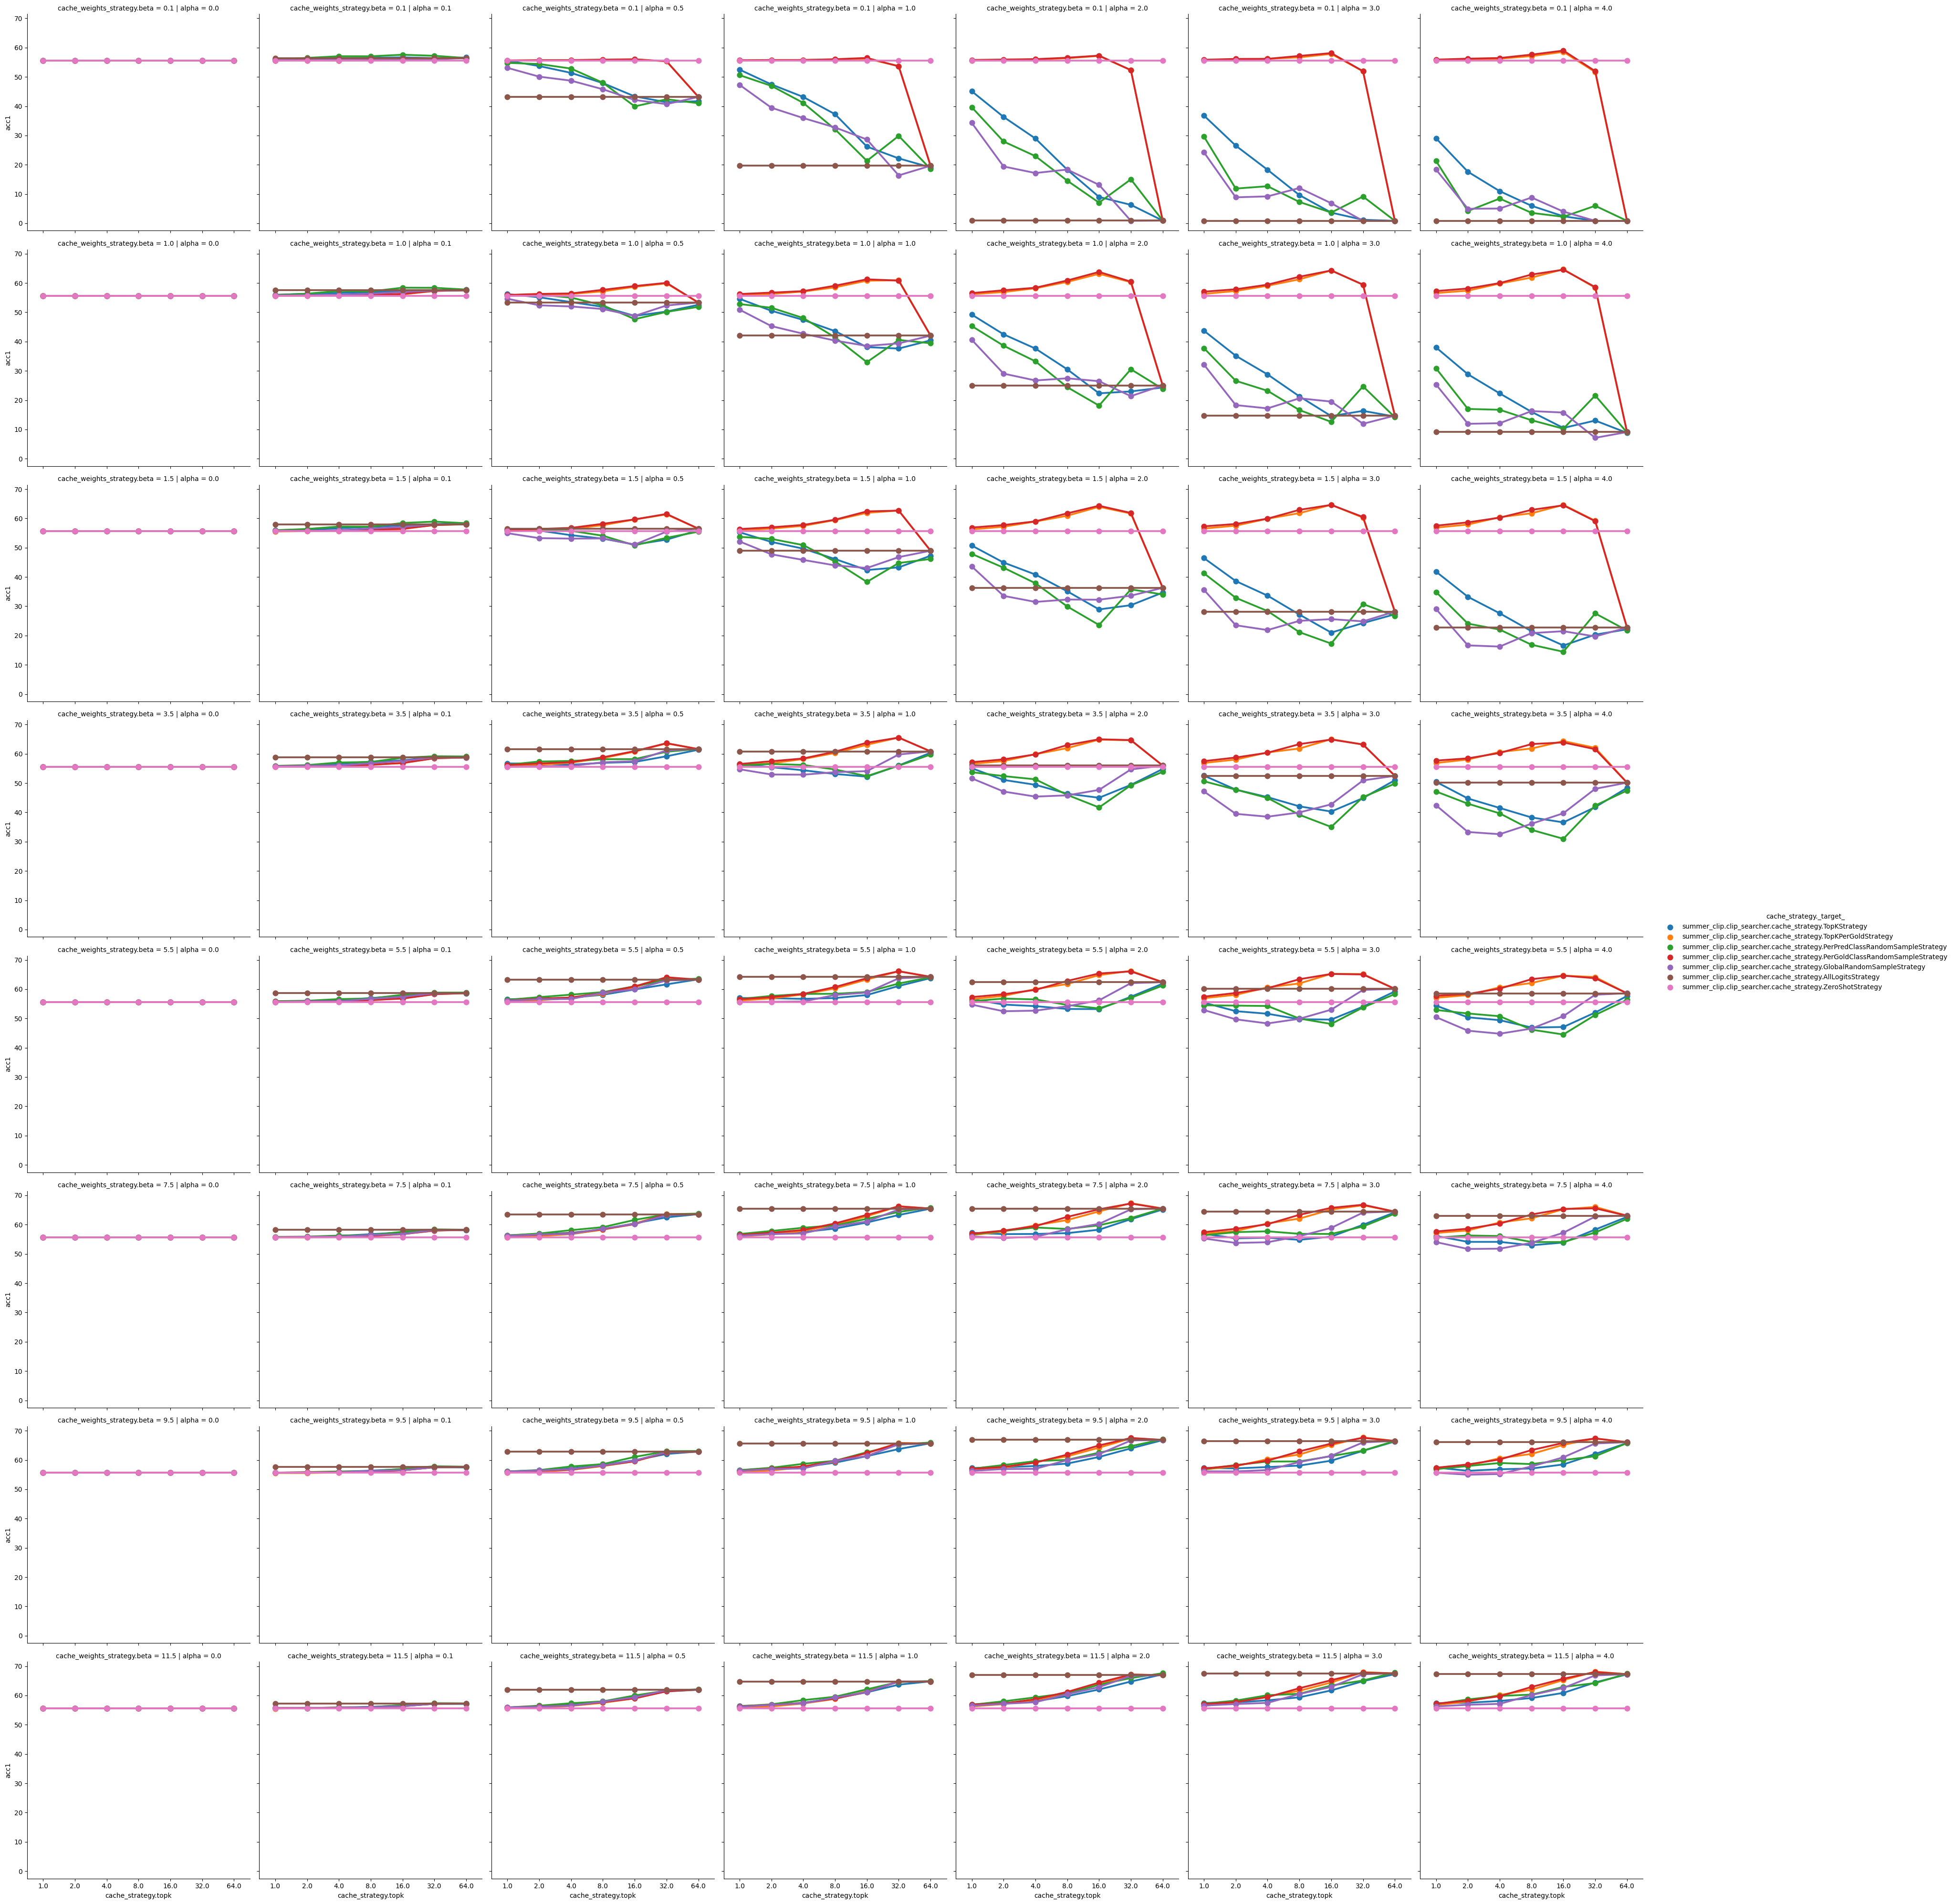

In [28]:
sns.catplot(
    data=part_df, x='cache_strategy.topk', y='acc1', col='alpha',
    row='cache_weights_strategy.beta', kind='point', hue='cache_strategy._target_'
)
plt.savefig('data/clip_search_8.pdf')